The task is to compare the scaling exponents in Heap's law for different languages. To do this, take several (preferably more than 10) items occurring in two languages (e.g., English and French), in each case count the beta exponent in Heap's law, and determine the correlations of the series so obtained (e.g., scipy.stats.pearsonr), along with the p-value. In addition, please check what the beta exponents are when we do a random shuffle of the words in the books (df.reshuffle plus fill from zero position).

In [75]:
# the ebooks in Finnish had an insert from project gutenberg in English at the beginning and end. I expected that this might skew the results, so I cut the books in both languages to include the text from the 1st chapter / introduction to the *** END OF THE PROJECT GUTENBERG EBOOK ROBINSON CRUSOE *** tag.

# i used abbreviations:
# monsieur - Monsieur Beaucaire by Booth Tarkington
# bride - The bride of Lammermoor by Walter Scott
# christian - The Christian: A Story by Sir Hall Caine
# mountain - The Lost Mountain: A Tale of Sonora by Mayne Reid
# africa - In Savage Africa by Verney Lovett Cameron
# alice - Alice's Adventures in Wonderland by Lewis Carroll
# comedy - The Bath Comedy by Agnes Castle and Egerton Castle
# crusoe - Robinson Crusoe by Daniel Defoe
# flyer - The Red Battle Flyer by Freiherr von Manfred Richthofen
# munchausen - The Red Battle Flyer by Freiherr von Manfred Richthofen
# paul - Paul ja Virginia by Bernardin de Saint-Pierre
# peter - Peter Pan by J. M. Barrie
# samuel The History of Samuel Titmarsh and the Great Hoggarty Diamond by Thackeray
# tristan - The Romance of Tristan and Iseult by Joseph Bédier

In [76]:
# Importing libraries 
import tmtoolkit as tm
from tmtoolkit.corpus import Corpus
import spacy
import statsmodels.formula.api as sm
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.patches as mpatches


In [77]:
# preparing and cleaning word corpus for all books in given language
def prepare_corp(lang: str):
    corp = tm.corpus.Corpus.from_folder("Lab_2_docs\\books_"+lang, language=lang, load_features=[])
    tm.corpus.remove_punctuation(corp)
    tm.corpus.to_lowercase(corp)
    tm.corpus.remove_tokens(corp, "")
    heap = tm.corpus.tokens_table(corp)
    _, doc_labels, _ = tm.corpus.dtm(corp, return_doc_labels=True, return_vocab=True)
    return corp, heap, doc_labels

In [78]:
# heap law: the number of unique words scales exponentially with the total number of words
# V ~ N**beta
# creating cumsum to check this thesis
def heap_calculate(shuffle: bool, corp, heap):
    if shuffle:
        for i in corp.doc_labels:
            mask = heap['doc'] == i  
            heap.loc[mask, 'token'] = random.sample(list(heap.loc[mask, 'token']), len(heap.loc[mask, 'token']))

    heap["V"] = ~heap.duplicated(subset = ["doc", "token"])
    heap["position"] += 1
    heap["V"] = heap.groupby("doc")["V"].cumsum()
    return heap

In [79]:
# calculation of beta parameter
def update_beta(lang: str, shuffle: bool, doc_labels, heap, df):
    col = "beta_" + lang
    if shuffle == True:
        col += '_shuffle'

    for i in doc_labels:
        model = sm.ols("np.log10(V)~np.log10(position)", data = heap[heap.doc==i]).fit()
        B, beta = model.params
        df.loc[df['title'] == i, col] = beta
    return df

In [80]:
def shuffle(corp,heap):
    for i in corp.doc_labels:
        mask = heap['doc'] == i  
        heap.loc[mask, 'token'] = random.sample(list(heap.loc[mask, 'token']), len(heap.loc[mask, 'token']))
    return heap

In [81]:
def plotting(lang: str, shuffle: bool, heap,xx):
    sns.lineplot(heap, x = "position", y="V", hue = "doc", legend=False)
    # A hypothetical case where each word is new
    plt.plot(xx, xx, "--",color="black",label='heap - 1st part')
    # realistic Heap's law
    plt.plot(xx, 20*xx**0.5, "--", color = "red", label='heap - 2nd part')
    plt.title(f"Heap's law for {lang}, shuffle = {shuffle}")
    plt.xscale('log')
    plt.yscale('log')

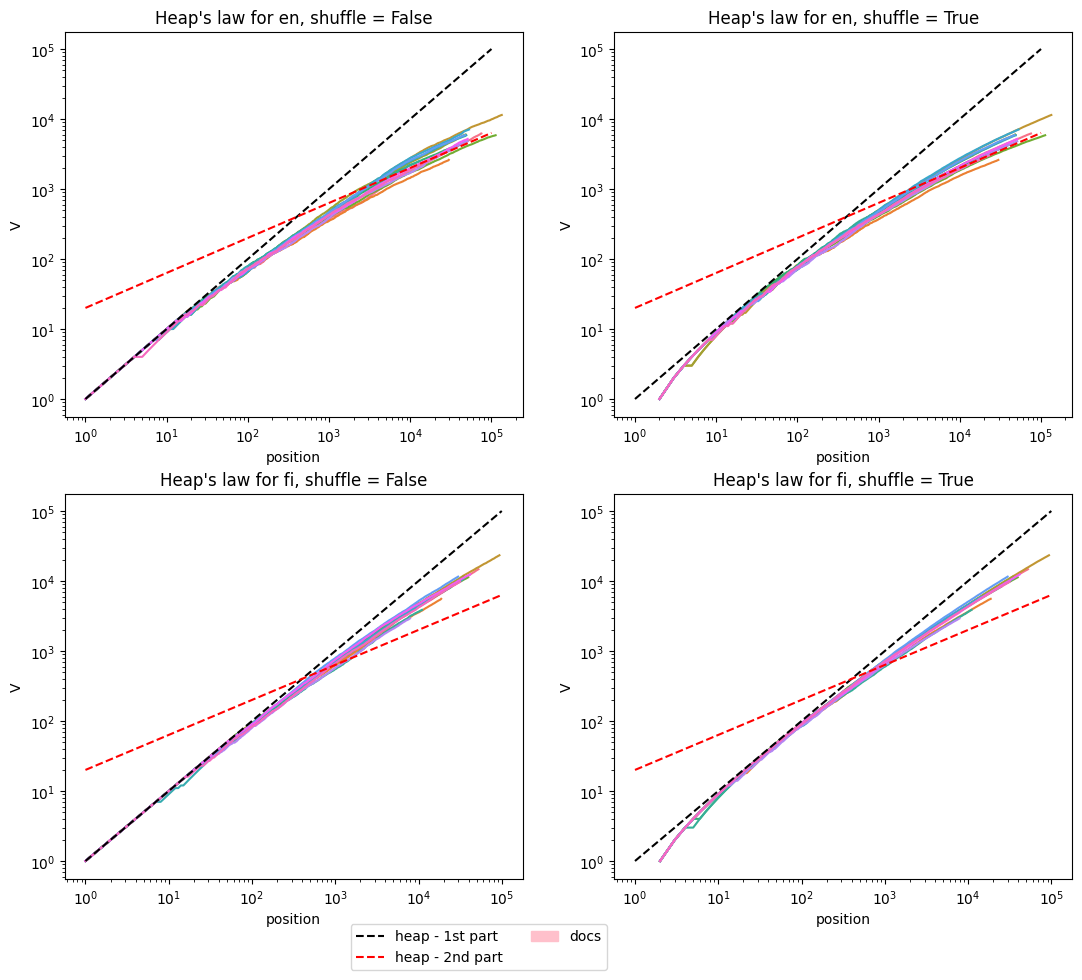

In [82]:
languages = ['en','fi']
df = pd.DataFrame(columns=['title', 'beta_en', 'beta_fi','beta_en_shuffle','beta_fi_shuffle'])
xx = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000])
plt.figure(figsize=(13,11))

#english
spacy.load('en_core_web_sm')
corp, heap, doc_labels = prepare_corp(languages[0])
df['title']=doc_labels
heap = heap_calculate(False, corp, heap)
df = update_beta(languages[0], False, doc_labels, heap, df)
plt.subplot(2, 2, 1)
plotting(languages[0], False, heap, xx)

#english with shuffle
heap = heap_calculate(True, corp, heap)
df = update_beta(languages[0], True, doc_labels, heap, df)

plt.subplot(2, 2, 2)
plotting(languages[0], True, heap, xx)

#french
spacy.load('fi_core_news_sm')
corp, heap, doc_labels = prepare_corp(languages[1])
df['title']=doc_labels
heap = heap_calculate(False, corp, heap)
df = update_beta(languages[1], False, doc_labels, heap, df)
plt.subplot(2, 2, 3)
plotting(languages[1], False, heap, xx)

#french with shuffle
heap = heap_calculate(True, corp, heap)
df = update_beta(languages[1], True, doc_labels, heap, df)
plt.subplot(2, 2, 4)
plotting(languages[1], True, heap, xx)

handles, labels = plt.gca().get_legend_handles_labels()
patch = mpatches.Patch(color='pink', label='docs')
handles.append(patch) 
plt.legend(handles = handles, bbox_to_anchor=(0,-0.1), ncol=2)


In [83]:
df

,title,beta_en,beta_fi,beta_en_shuffle,beta_fi_shuffle
0,africa,0.644678,0.788278,0.590278,0.767174
1,alice,0.599619,0.766984,0.585263,0.769052
2,bride,0.609679,0.748056,0.60767,0.758704
3,comedy,0.638743,0.805204,0.646182,0.798921
4,crusoe,0.560526,0.768965,0.53397,0.754143
5,flyer,0.612056,0.777658,0.608629,0.78356
6,monsieur,0.723153,0.825181,0.67554,0.804698
7,mountain,0.637452,0.780687,0.637777,0.777246
8,munchausen,0.674052,0.830184,0.660324,0.823572
9,paul,0.656333,0.803107,0.650275,0.816615


In [84]:
df=df.apply(pd.to_numeric,errors='ignore')

print(pearsonr(df['beta_en'], df['beta_fi']))
print(pearsonr(df['beta_en_shuffle'], df['beta_fi_shuffle']))

PearsonRResult(statistic=0.7223709765235022, pvalue=0.0052895060376469205)
PearsonRResult(statistic=0.81674418324463, pvalue=0.0006557604660661272)


C:\Users\paula\AppData\Local\Temp\ipykernel_20416\2745274531.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df=df.apply(pd.to_numeric,errors='ignore')


In [85]:
#for shuffled docs p-value comes out smaller (~0.005 vs ~0.0004)
#
# In English, heap's law is clearly more noticeable